In [1]:
library(spdep)
library(spatstat)
library(GISTools)
library(rgdal)
library(maptools)
library(RColorBrewer)
library(GWmodel)
library(e1071)

Warning message:
"package 'spdep' was built under R version 3.6.2"
Loading required package: sp

Loading required package: spData

Warning message:
"package 'spData' was built under R version 3.6.2"
To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

Loading required package: sf

Warning message:
"package 'sf' was built under R version 3.6.2"
Linking to GEOS 3.6.1, GDAL 2.2.3, PROJ 4.9.3

Warning message:
"package 'spatstat' was built under R version 3.6.2"
Loading required package: spatstat.data

Warning message:
"package 'spatstat.data' was built under R version 3.6.2"
Loading required package: nlme

Loading required package: rpart

Warning message:
"package 'rpart' was built under R version 3.6.2"

spatstat 1.62-2       (nickname: 'Shape-shifting lizard') 
For an introduction to spatstat, type 'beginner' 


Warning message:
"package 'GISTools' was built under R ver

In [2]:
# converts an unprojected shapefile into Albers equal area projection using NAD83 datum 
# with appropriate parallels and longitude of origin to minimize distortion

to_aea <- function(shp) {
    ct<-readOGR(shp)
    lat.range <- as.numeric(st_bbox(ct)$ymax) - as.numeric(st_bbox(ct)$ymin)
    lat1 <- as.numeric(st_bbox(ct)$ymin) + lat.range / 6
    lat2 <- as.numeric(st_bbox(ct)$ymax) - lat.range / 6
    lat0 <- (lat1 + lat2) / 2
    long.origin <- (as.numeric(st_bbox(ct)$xmin) + as.numeric(st_bbox(ct)$xmax)) / 2
    proj=sprintf("+proj=aea +lat_1=%f +lat_2=%f +lat_0=%f +lon_0=%f +x_0=0 +y_0=0 +datum=NAD83", lat1, lat2, lat0, long.origin)
    ct.aea<-spTransform(ct, proj)
    return(ct.aea)
}

In [3]:
# convert the data to Albers Equal Area
ct.aea <- to_aea("censustract.shp")

OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\orms0027\Documents\day_of_data\censustract.shp", layer: "censustract"
with 732 features
It has 5 fields
Integer64 fields read as strings:  Sum_TOTPOP Sum_MINORI 


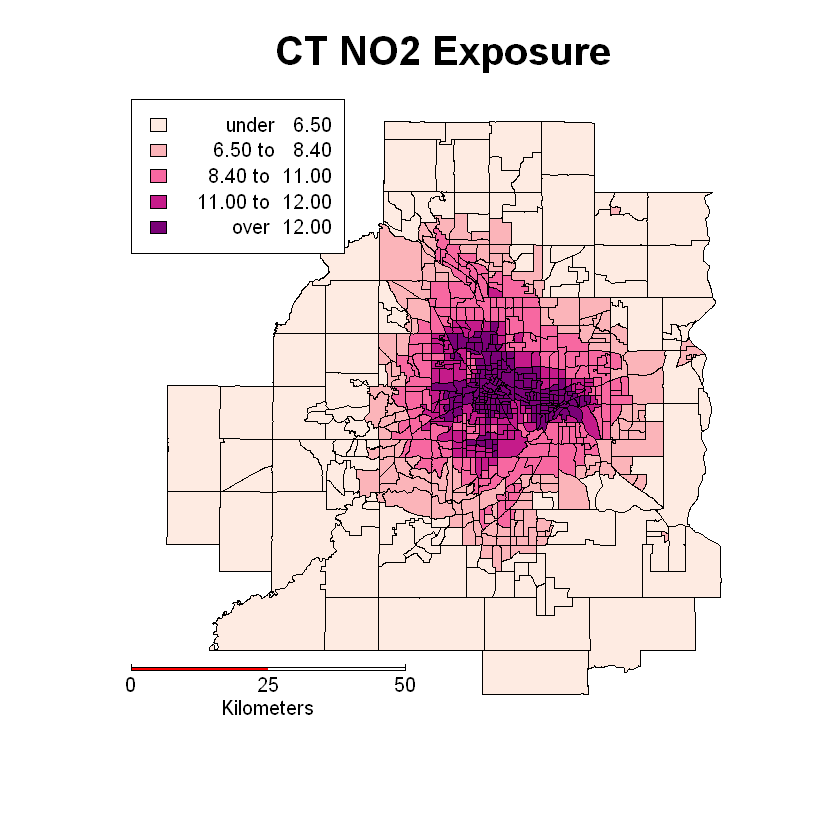

In [4]:
# make a choropleth map of NO2 exposure to visualize data
ctNO2 <- as.numeric(ct.aea$Avg_Avg_NO)
ctNO2.shade <- auto.shading(ctNO2,n=5,cols = brewer.pal(5,"RdPu"))
choropleth(ct.aea,ctNO2,shading=ctNO2.shade)
choro.legend(-57000,56500, ctNO2.shade,fmt="%6.2f")
title("CT NO2 Exposure",cex.main=2)
map.scale(-32000,-48000,50000,"Kilometers",2,25,sfcol='red')

In [ ]:
# convert spatial data to a contiguity graph to make it easy to tell which regions are neighbors
ct.nb<-poly2nb(ct.aea)

# Calculating spatial autocorrelation requires constructing a row-standardized neighborhood weights matrix W
# for each row in W, all non-neighbors have a value of 0, while each neighbor has a value such that the row sum is 1
# (i.e. if a region has 2 neighbors, they will each have a value of 0.5)
ct.lw<- nb2listw(ct.nb)
ct.lw

In [5]:
# Calculate Local Moran's I.  This statistic is a measure of how similar a region is to neighboring regions.
# High local Moran's I values indicate a high degree of similarity 
# the localmoran() function will also calculate a p value of the statistic
ctNO2.mor <- localmoran(ctNO2,ct.lw)

Characteristics of weights list object:
Neighbour list object:
Number of regions: 732 
Number of nonzero links: 4548 
Percentage nonzero weights: 0.8487862 
Average number of links: 6.213115 

Weights style: W 
Weights constants summary:
    n     nn  S0       S1       S2
W 732 535824 732 254.8607 3036.543

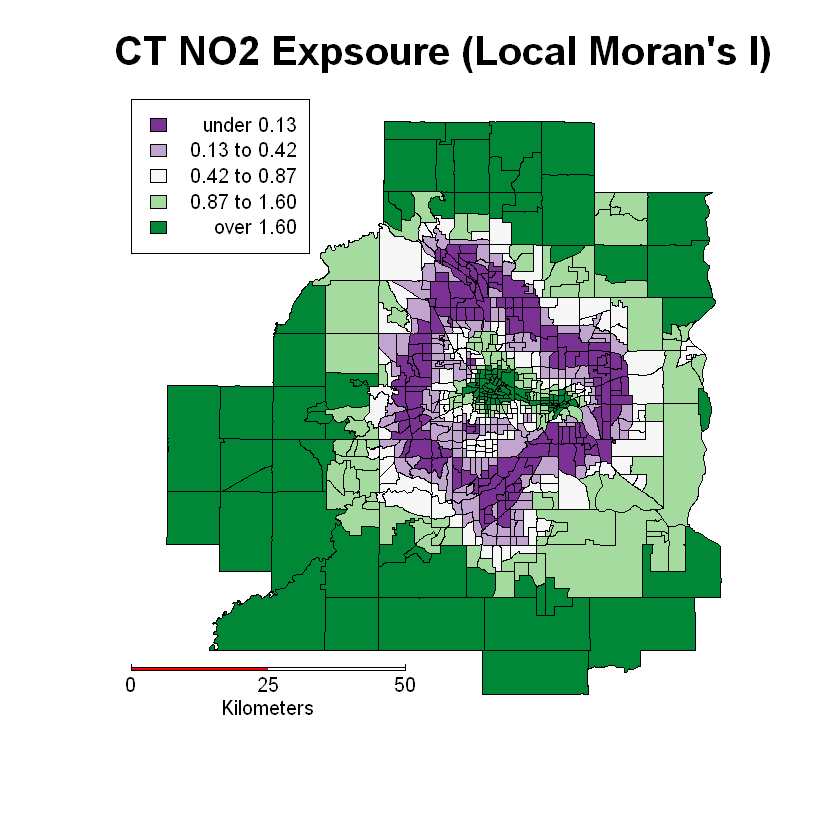

In [6]:
# Make a choropleth map of Moran's I values to see clusters of similar values
ctNO2.mor.Ii <- as.numeric(ctNO2.mor[,'Ii']) # the I statistic
ctNO2mor.shade <- auto.shading(ctNO2.mor.Ii, cols=brewer.pal(5,"PRGn"))
choropleth(ct.aea,ctNO2.mor[,1],shading=ctNO2mor.shade)
choro.legend(-57000,56500, ctNO2mor.shade,fmt="%1.2f")
title("CT NO2 Expsoure (Local Moran's I)",cex.main=2)
map.scale(-32000,-48000,50000,"Kilometers",2,25,sfcol='red')

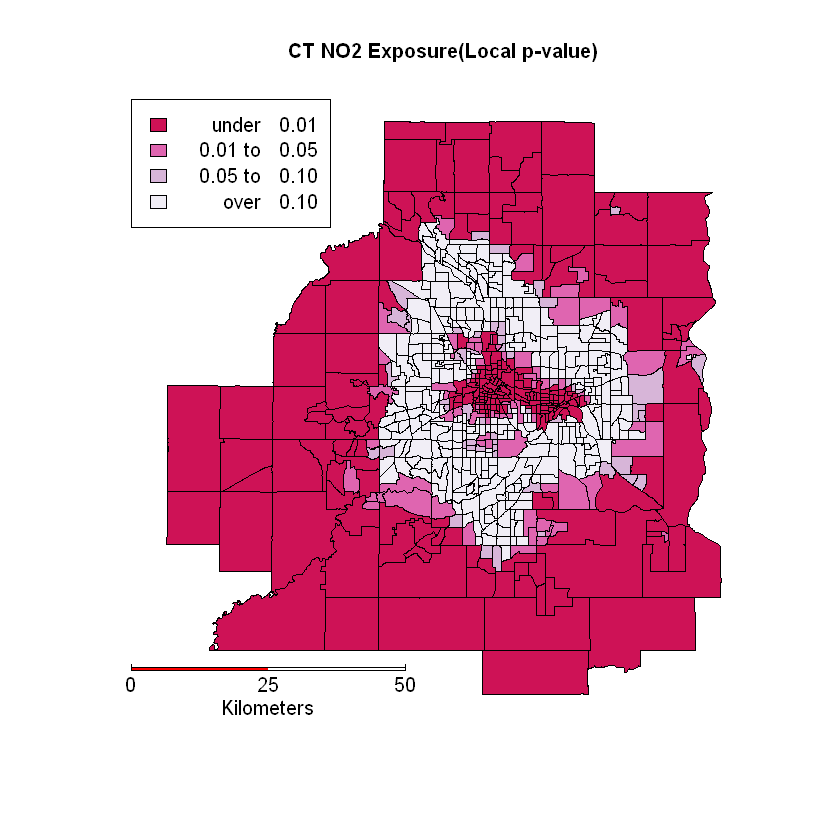

In [7]:
# Make a choropleth map of of p values to see where the statistically significant I values are located 

pvalNO2ct.shade <- shading(c(0.01,0.05,0.1),cols = rev(brewer.pal(4,'PuRd')))
choropleth(ct.aea,ctNO2.mor[,5],shading=pvalNO2ct.shade)
choro.legend(-57000,56500, pvalNO2ct.shade,fmt="%6.2f")
title("CT NO2 Exposure(Local p-value)", cex.main=1)
map.scale(-32000,-48000,50000,"Kilometers",2,25,sfcol='red')